In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'malimg-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from malimg-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(9339, 2048)

In [9]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 12.9min


[CV] .............. C=0.01, gamma=1e-06, score=0.315846, total= 7.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.315846, total=10.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=10.4min
[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=10.4min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.315846, total=10.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=10.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.315846, total=10.3min
[CV] .............. C=0.01, gamma=1e-06, score=0.315846, total=10.3min
[CV] C

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 16.3min


[CV] .............. C=0.01, gamma=1e-07, score=0.315846, total=10.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.315846, total=10.3min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.315846, total=10.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.315846, total=10.8min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.315846, total=11.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.315846, total=11.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=10.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 17.2min


[CV] ............... C=0.01, gamma=0.01, score=0.629015, total= 7.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.629015, total= 7.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.630621, total= 7.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.710385, total= 6.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.630086, total= 7.2min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.711991, total= 6.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.710921, total= 6.9min
[CV] .............. C=0.01, gamma=0.001, score=0.711991, total= 6.9min
[CV] C

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 28.5min


[CV] ............. C=0.01, gamma=0.0001, score=0.486081, total= 8.9min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.486081, total= 8.8min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.486081, total= 8.9min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=0.1, score=0.430942, total=20.3min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=0.1, score=0.431478, total=20.3min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.430942, total=20.3min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.434154, total=20.3min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 59.5min


[CV] .............. C=0.01, gamma=100.0, score=0.401499, total=26.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total= 9.4min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.401499, total=26.0min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.401499, total=26.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total= 9.3min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.401499, total=26.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total= 9.4min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 61.4min


[CV] ............. C=0.01, gamma=1000.0, score=0.401499, total=25.8min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.401499, total=25.8min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.401499, total=25.9min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.315846, total= 9.4min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.315846, total= 9.4min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total= 9.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.740364, total= 5.7min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 74.9min


[CV] ............... C=0.1, gamma=1e-06, score=0.315846, total= 9.1min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.315846, total= 9.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-08, score=0.315846, total= 9.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.315846, total= 9.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.315846, total= 9.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.315846, total= 9.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.748929, total= 5.8min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 78.5min


[CV] ............... C=0.1, gamma=0.001, score=0.933084, total= 2.5min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.927730, total= 2.5min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.929336, total= 2.5min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.932013, total= 3.7min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.932548, total= 3.6min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................ C=0.1, gamma=0.01, score=0.931478, total= 3.7min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................ C=0.1, gamma=0.01, score=0.928801, total= 3.7min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 112.7min


[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.470021, total=29.6min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.468415, total=29.7min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.452891, total=28.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.455567, total=29.6min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.453961, total=29.6min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.453961, total=29.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=100.0, score=0.450214, total=28.2min
[CV] C

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 123.4min


[CV] ............... C=1.0, gamma=1e-05, score=0.747323, total= 5.6min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.748394, total= 5.5min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.751071, total= 5.5min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.315846, total= 8.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.315846, total= 8.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.315846, total= 8.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.933619, total= 2.1min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 129.0min


[CV] .............. C=1.0, gamma=0.0001, score=0.936296, total= 2.0min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.929872, total= 2.0min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.929336, total= 2.0min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.486081, total= 9.0min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.486081, total= 9.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.958244, total= 1.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.961456, total= 1.1min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 159.6min


[CV] ................. C=1.0, gamma=0.1, score=0.787473, total=26.1min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.791221, total=26.1min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.538009, total=27.6min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.544968, total=27.7min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.540685, total=27.6min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.543362, total=27.6min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.546574, total=27.6min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 172.5min


[CV] .............. C=10.0, gamma=1e-05, score=0.935760, total= 2.1min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=1.0, gamma=1000.0, score=0.473233, total=27.3min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.315846, total= 8.8min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.315846, total= 9.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.315846, total= 9.2min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.315846, total= 9.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.963597, total=  52.3s
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 177.9min


[CV] .............. C=10.0, gamma=1e-08, score=0.315846, total= 9.1min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.486081, total= 9.1min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.315846, total= 9.1min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.486081, total= 9.1min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.486081, total= 9.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.991970, total=  51.9s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.991435, total=  54.6s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 209.6min


[CV] ................ C=10.0, gamma=1.0, score=0.555139, total=27.8min
[CV] ................ C=10.0, gamma=1.0, score=0.552463, total=28.0min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.551927, total=27.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.554069, total=28.0min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.552463, total=27.8min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.508565, total=27.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.506959, total=27.6min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 221.6min


[CV] ............ C=100.0, gamma=0.0001, score=0.987152, total=  44.3s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-05, score=0.968951, total=  56.7s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.747323, total= 5.4min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.966274, total=  55.9s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.962527, total=  55.7s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.315846, total= 8.8min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.989829, total=  44.3s
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 226.2min


[CV] ............. C=100.0, gamma=1e-08, score=0.486081, total= 8.8min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.486081, total= 8.8min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.486081, total= 8.8min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.486081, total= 8.8min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.982869, total= 2.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.986081, total= 2.7min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.985546, total= 2.6min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 260.9min


[CV] ............ C=100.0, gamma=1000.0, score=0.476445, total=27.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.508565, total=29.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............. C=100.0, gamma=100.0, score=0.480728, total=29.2min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............. C=100.0, gamma=100.0, score=0.475375, total=29.3min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.476445, total=29.5min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.476981, total=29.3min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.963597, total=  52.9s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 266.9min


[CV] ............ C=1000.0, gamma=0.001, score=0.990364, total=  51.4s
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.990364, total=  51.0s
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.990899, total=  52.0s
[CV] ............ C=1000.0, gamma=0.001, score=0.988223, total=  52.0s
[CV] C=1000.0, gamma=1.0 .............................................
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.486081, total= 8.9min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.486081, total= 8.9min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............. C=1000.0, gamma=0.01, score=0.982869, total= 2.7min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 302.3min


[CV] ............. C=1000.0, gamma=10.0, score=0.506959, total=27.7min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] .............. C=1000.0, gamma=1.0, score=0.555139, total=29.7min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] .............. C=1000.0, gamma=1.0, score=0.552463, total=29.8min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.508030, total=27.4min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.505353, total=27.6min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ............ C=1000.0, gamma=100.0, score=0.479122, total=27.4min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ............ C=1000.0, gamma=100.0, score=0.479122, total=27.4min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 306.9min


[CV] ........... C=1000.0, gamma=1000.0, score=0.476445, total=29.5min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.987152, total=  42.8s
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.929872, total= 2.1min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.929336, total= 2.0min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-05, score=0.988223, total=  37.6s
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ........... C=10000.0, gamma=1e-05, score=0.983405, total=  37.3s
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.986081, total=  37.5s
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 337.8min


[CV] ............. C=10000.0, gamma=0.1, score=0.796574, total=25.1min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............. C=10000.0, gamma=0.1, score=0.795503, total=25.2min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.552463, total=27.8min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.934690, total= 2.0min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.554069, total=27.8min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.552463, total=27.9min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=10.0, score=0.508565, total=27.8min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 345.8min


[CV] .......... C=100000.0, gamma=1e-07, score=0.988223, total=  42.4s
[CV] C=100000.0, gamma=0.001 .........................................
[CV] .......... C=100000.0, gamma=1e-06, score=0.982869, total=  37.8s
[CV] C=100000.0, gamma=0.001 .........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.985546, total=  39.1s
[CV] .......... C=100000.0, gamma=1e-05, score=0.983405, total=  36.8s
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.988758, total=  38.1s
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.988223, total=  38.0s
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.988758, total=  39.6s
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 377.8min


[CV] ............ C=100000.0, gamma=0.1, score=0.785332, total=27.0min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.796574, total=27.0min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.795503, total=27.0min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.960385, total=  56.6s
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ............ C=100000.0, gamma=1.0, score=0.555139, total=28.2min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.963597, total=  55.9s
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.964668, total=  57.1s
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 383.9min


[CV] ......... C=1000000.0, gamma=1e-06, score=0.988758, total=  39.2s
[CV] C=1000000.0, gamma=0.001 ........................................
[CV] ......... C=1000000.0, gamma=1e-06, score=0.987687, total=  37.6s
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.985546, total=  37.9s
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-06, score=0.988223, total=  39.3s
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-06, score=0.982869, total=  38.7s
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.988758, total=  37.7s
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.988758, total=  39.3s
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 415.5min


[CV] ........ C=10000000.0, gamma=1e-09, score=0.966809, total=  40.7s
[CV] C=10000000.0, gamma=1e-09 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.975910, total=  40.5s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.971627, total=  42.4s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.970021, total=  43.1s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-08, score=0.985546, total=  38.7s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.966274, total=  39.9s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........... C=1000000.0, gamma=1.0, score=0.552463, total=28.1min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 422.1min


[CV] ........ C=10000000.0, gamma=1e-05, score=0.988758, total=  39.4s
[CV] C=10000000.0, gamma=0.01 ........................................
[CV] ........ C=10000000.0, gamma=1e-05, score=0.988223, total=  39.4s
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=1e-05, score=0.983405, total=  39.0s
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.989829, total=  38.2s
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.984475, total=  36.9s
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.986081, total=  40.2s
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.988758, total=  38.6s
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 637 tasks      | elapsed: 456.2min


[CV] ......... C=10000000.0, gamma=10.0, score=0.505889, total=27.9min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.985011, total=  41.1s
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ......... C=10000000.0, gamma=10.0, score=0.505353, total=27.9min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.989293, total=  38.6s
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.989293, total=  41.0s
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.986081, total=  42.5s
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.982334, total=  38.7s
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 460.7min


[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.990899, total=  52.4s
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.988223, total=  47.5s
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.990364, total=  47.9s
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ........ C=10000000.0, gamma=100.0, score=0.475375, total=29.1min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ........ C=10000000.0, gamma=100.0, score=0.480728, total=29.1min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ........ C=100000000.0, gamma=0.01, score=0.982869, total= 2.5min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ........ C=100000000.0, gamma=0.01, score=0.982334, total= 2.5min
[CV] C

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed: 496.1min


[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.988223, total=  37.4s
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ........ C=100000000.0, gamma=10.0, score=0.505353, total=29.0min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.988758, total=  38.3s
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ........ C=100000000.0, gamma=10.0, score=0.505889, total=29.4min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.982869, total=  36.8s
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.985546, total=  38.1s
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.988223, total=  36.7s
[CV] C

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 510.7min


[CV] ...... C=100000000.0, gamma=1000.0, score=0.476981, total=27.8min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ...... C=100000000.0, gamma=1000.0, score=0.473233, total=27.7min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ...... C=100000000.0, gamma=1000.0, score=0.476981, total=27.9min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.792827, total=25.2min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.796574, total=25.3min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.795503, total=26.4min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.785332, total=26.3min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed: 535.9min


[CV] ..... C=10000000000.0, gamma=1e-05, score=0.988223, total=  39.7s
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=10000000000.0, gamma=1e-05, score=0.983405, total=  38.7s
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.986081, total=  38.4s
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.989293, total=  38.9s
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.989829, total=  42.3s
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.988758, total=  38.6s
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.984475, total=  37.4s
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed: 584.1min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [10]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.001} - score: 0.9895


In [11]:
top_model.cv_results_

{'mean_fit_time': array([  563.72703686,   505.77359476,   511.04766474,   495.35252919,
          521.59738774,   448.3674706 ,   346.24594383,   373.72362819,
         1126.7757288 ,  1482.14180384,  1469.97358699,  1473.2777144 ,
         1469.30325522,   467.46996531,   459.1045958 ,   456.80415263,
          457.139394  ,   467.96356182,   282.35102458,   111.051898  ,
          186.42388983,  1469.67963734,  1687.34921784,  1656.43038983,
         1599.00127044,  1592.14208331,   463.3221786 ,   457.64778328,
          463.44800386,   451.40182576,   271.33337574,    86.85733509,
           42.71900077,   140.90329385,  1467.76544337,  1573.7702158 ,
         1583.07964191,  1626.32346139,  1593.37087941,   447.21206102,
          453.1077692 ,   461.31023378,   279.50121722,    87.54480162,
           33.84155641,    35.24840117,   136.81939359,  1506.91791878,
         1592.70224652,  1646.39918227,  1635.54351993,  1638.0900075 ,
          456.26948419,   440.94759684,   268.8

In [12]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0000000000000001e-09},
 mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.48608, std: 0.00000, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.71092, std: 0.00102, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.62944, std: 0.00079, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.43212, std: 0.00128, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 100.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 1000.0},
 mean: 0.31585, std: 0.00000, params: {'C': 0.100

In [13]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

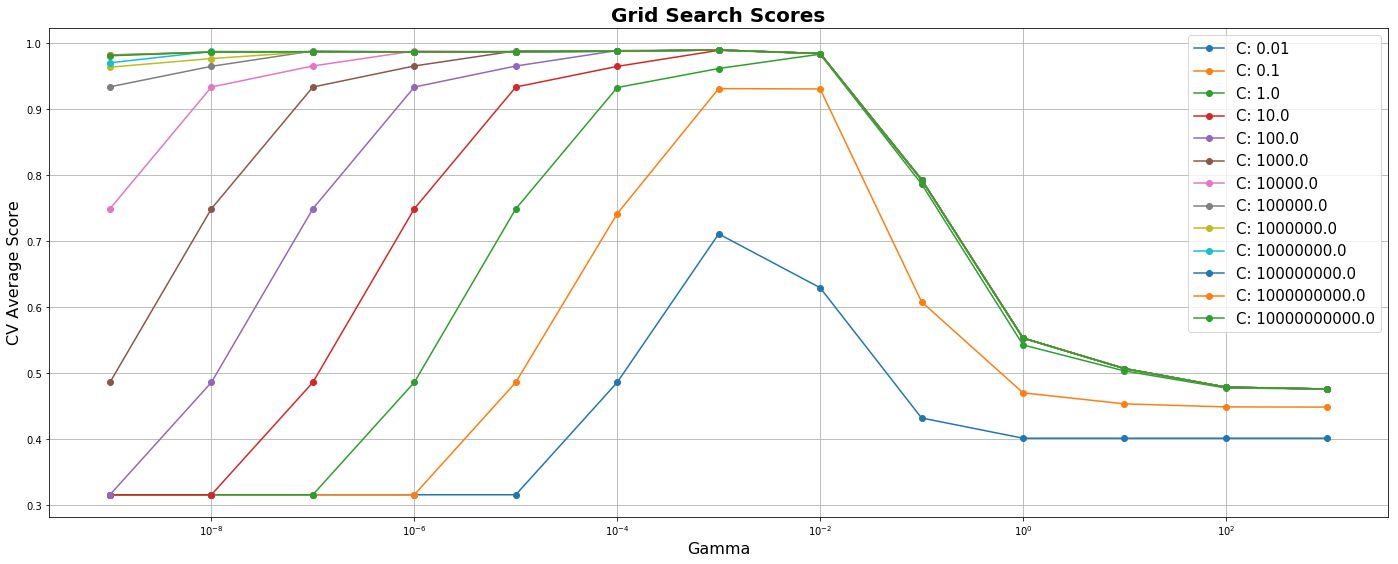

In [14]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


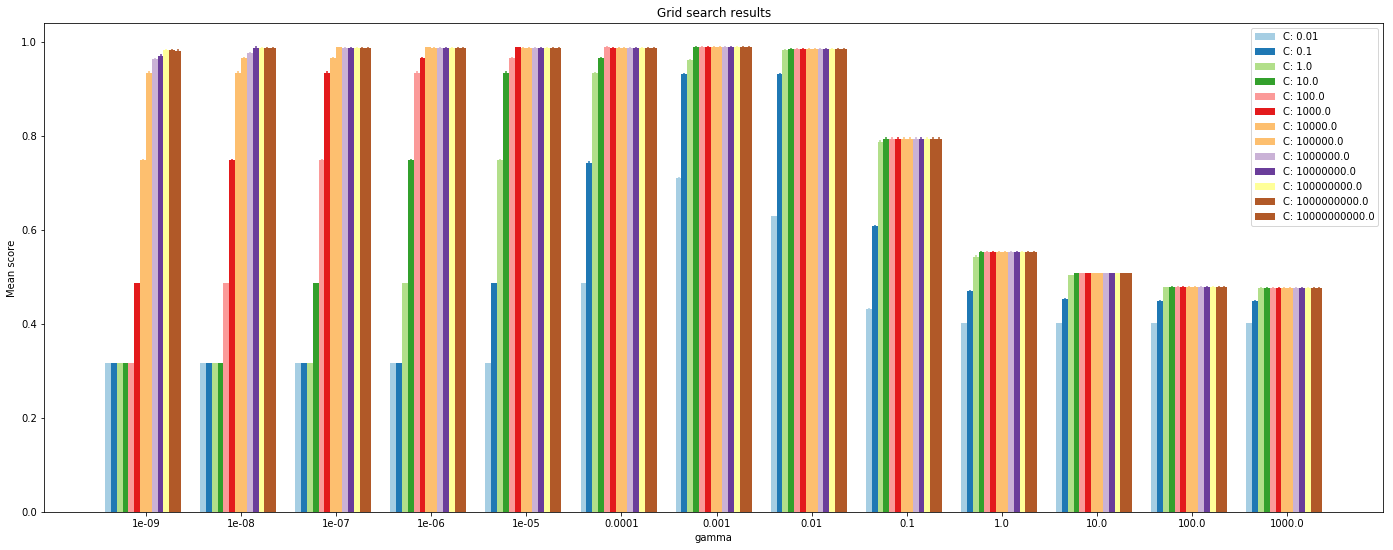

In [15]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


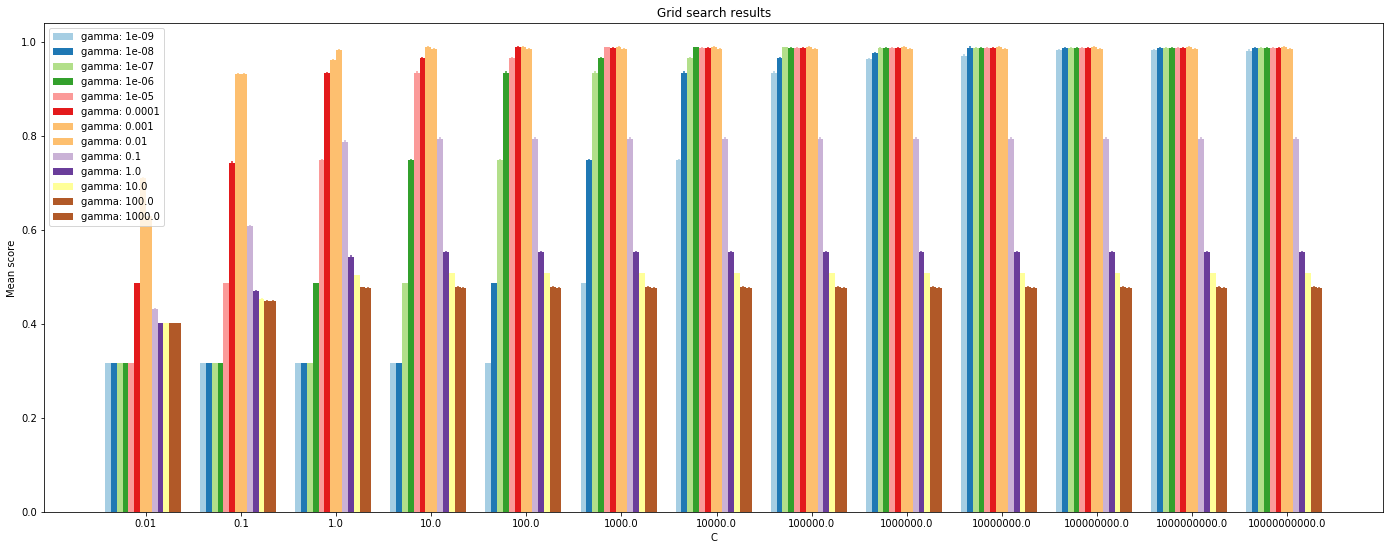

In [16]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [24]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=100.0,gamma=0.001)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

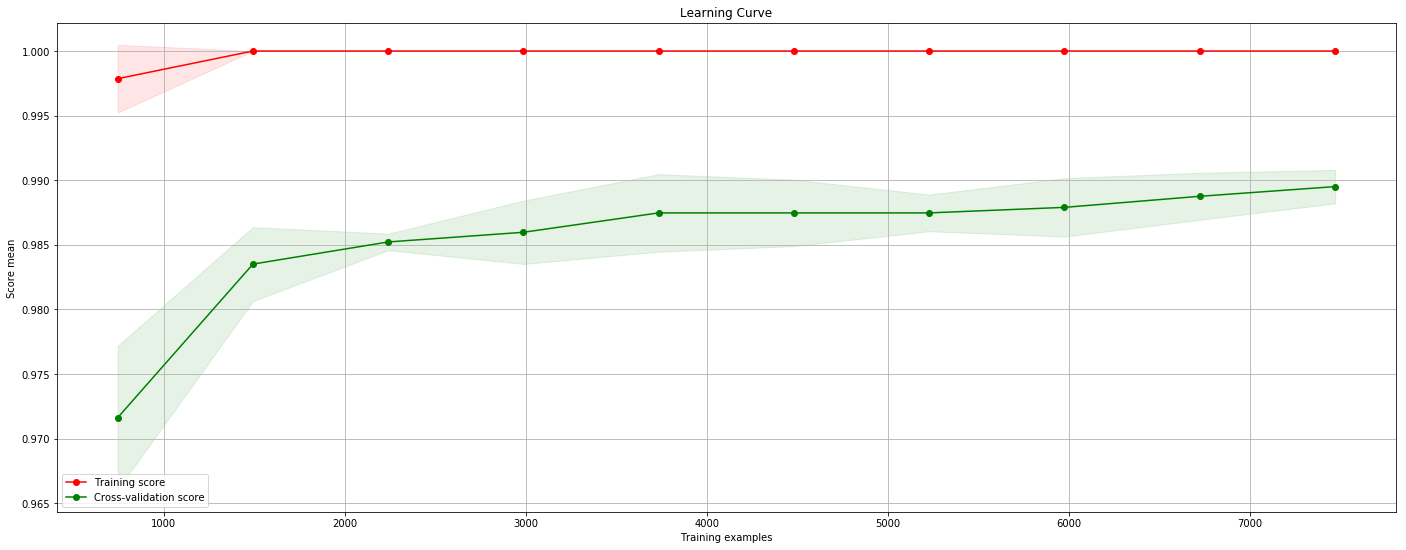

In [25]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()